# Radiative Processes for Black Holes

## 5. Geodesic Integration

This repository contains python functions that are useful for integrating geodesics.

In [1]:
# We will use JAX for autodiff

from jax import numpy as np
from jax import jacfwd
from jax import jit
from jax.numpy        import dot
from jax.numpy.linalg import inv

from matplotlib import pyplot as plt

from tqdm import tqdm

### 5.1. The Cartesian Kerr-Schild coordinates

Thanks to autodiff, we only need to implement the metric for the Kerr-Schild coordinates $g_{\mu\nu}$.
All other functions, such as the inverse metric $g^{\mu\nu}$ and the Jacobian of the metric $g_{\mu\nu,\alpha}$,
can be computed automatically using JAX.

In [2]:
eta = np.asarray([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

@jit
def metric(x):
    r = np.sqrt(x[1]*x[1] + x[2]*x[2] + x[3]*x[3])
    f = 2/r
    l = np.asarray([1, x[1]/r, x[2]/r, x[3]/r])
    return eta + f * l[:,np.newaxis] * l[np.newaxis,:]

def imetric(x):
    return inv(metric(x))

dmetric = jacfwd(metric)

### 5.2. 4th-order Runge-Kutta method

See the numerical recipes or CK's PHYS 105A [lecture note](https://github.com/uarizona-2021spring-phys105a/phys105a/blob/main/12/ode2.ipynb) for reference.

In [3]:
def RK4(rhs, state, dt):
    k1 = dt * rhs(state           )
    k2 = dt * rhs(state + 0.5 * k1)
    k3 = dt * rhs(state + 0.5 * k2)
    k4 = dt * rhs(state +       k3)
    return state + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6

### 5.3. The Geodesic Equation

In [4]:
def rhs(state):
    x  = state[:4]
    v  = state[4:]
    
    ig = imetric(x)
    jg = dmetric(x)
    a  = (-       dot(ig, dot(dot(jg, v), v))
          + 0.5 * dot(ig, dot(v, dot(v, jg))))
    
    return np.concatenate([v, a])

### 5.4. Use the Code

In [5]:
# Here we configure the calculation

dt = 0.2 # Step size
N  = 500 # Number of integration steps
s0 = np.array([
    0, 20, 5.085, 1,
    1, -1, 0,   0,
], dtype=np.float32) # Initial conditions

In [6]:
# Construct the array to hold the results

states = [s0]

In [7]:
# Integrate the geodesic equation

for i in tqdm(range(N)):
    states.append(RK4(rhs, states[-1], dt))

S = np.array(states)
X = S[:,:4]
V = S[:,4:]

100%|██████████| 500/500 [00:12<00:00, 39.47it/s]


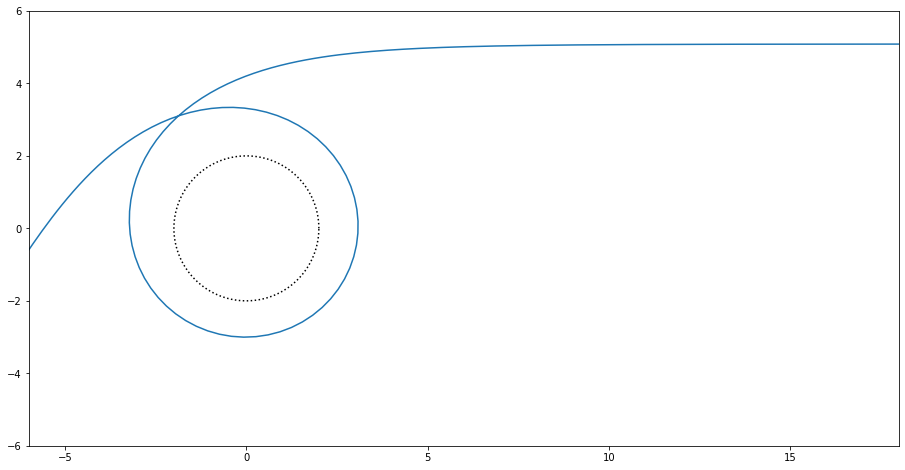

In [8]:
# Plot the result

fig, ax = plt.subplots(1,1,figsize=(16,8))

phi = np.arange(361) * np.pi / 180
ax.plot(2 * np.cos(phi), 2 * np.sin(phi), ':', color='k')

ax.plot(X[:,1], X[:,2])
ax.set_xlim(-6, 18)
ax.set_ylim(-6, 6)
ax.set_aspect('equal')

### 5.4. TODO

1. Verify the metric is implemented correctly.
2. Verif RK4 is implemented correctly.
3. Study JAX and verify the `rhs()` is implemented correctly.

4. Introduce spin to the problem by modifying `metric()`.

5. Generalize the metric and `rhs()` so that it accept 2D arrays as input: `state[n_states, n_particle]`

6. Optimize the implementation using jit etc.

7. Use a bisection method to solve for the boundary of the black hole shadow.

8. Add different spacetime.